# 08 - Using Google Vision Product Search Retail API

Vision API Product Search allows retailers to create products, each containing reference images that visually describe the product from a set of viewpoints. Retailers can then add these products to product sets.

When users query the product set with their own images, Vision API Product Search applies machine learning to compare the product in the user's query image with the images in the retailer's product set, and then returns a ranked list of visually and semantically similar results.


#### The workflow we're following in the notebook is as follows:

1) Create Product Set
2) Create Products
3) Add Products to the Products Set
4) Create Reference Images
5) Get Similar Images

### Before you get started

Create a multi-regional GCP bucket. Keep the bucket empty to store the image files which will be created later in this notebook.

In [ ]:
# URI that contents dataset of 300 images
GCS_URI = 'ENTER HERE' #"gs://zulily-image-data/image_data_300/images_300/"

# 1 - Set Up

### Import Libraries

In [3]:
from google.cloud import vision
from google.protobuf import field_mask_pb2 as field_mask

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gcsfs
from gcloud import storage
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

###  Setting up GCP Variables

In [12]:
# Enter the project ID 
PROJECT_ID ='q-gcp-4639-zulily-22-01' 
# For this workshop we will be using us-west1
LOCATION='us-west1'
# Unique Numeric ID for a project ending with '_'
PRODUCT_SET_ID = '9999_'

# 2 -  Preparing Dataset 

Here we are using Zulily's metadata. Out of 900,000 images we are using 300 to test out the product search API. The data contains information about the product like unique product id, description, category, color etc. 

We create a unique product_id ('new_product_id') column by appending the unique product_set_id to the product_id. This is only done for the workshop so same product can be uploaded multiple times in a project.

In [13]:
meta = pd.read_csv('image_300.csv')
x=[]
for i in range(len(meta['product_id'])):
    x.append(PRODUCT_SET_ID+str(meta['product_id'][i]))
meta.insert(loc=3,column='new_product_id', value=x)
meta=meta.drop(columns=['product_id'], axis=1)
meta.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1   new_product_id  \
0           0             0               0  9999_85204318.0   
1           1             1               1  9999_87080642.0   
2           2             2               2  9999_25545767.0   
3           3             3               3  9999_23708494.0   
4           4             5               5  9999_13976617.0   

   product_style_id   size            age_group        color  \
0          85204316    2XL           Adult  13+        WHITE   
1          87080603    7/8  Big Kid 6 - 9 years          NaN   
2          25545766      S           Adult  13+          NaN   
3          23708491      L           Adult  13+  Black Combo   
4          13976613  25/26  Big Kid 6 - 9 years   ROUGE NOIR   

                  tier1     tier2  ... product_gender brand_id  \
0               Apparel  Swimwear  ...         Female  41162.0   
1               Apparel  Swimwear  ...         Female  46031.0   
2               Apparel   Dresses  ...         Female   6261.0   
3               Apparel      Tops  ...         Female   4695.0   
4  Personal Accessories   Legwear  ...         Female    340.0   

            brand_name                  subcategory          category  \
0             Red Love                Missy Apparel    Womens Apparel   
1           Pixie Girl             Big Girl Apparel     Girls Apparel   
2  PinkBlush Maternity  Maternity & Nursing Apparel    Womens Apparel   
3            Laurie b.                Missy Apparel    Womens Apparel   
4       Eliane et Lena             Kids Accessories  Kids Accessories   

  department                                        description  \
0     Womens  <p>Flaunt your fun style poolside in this brig...   
1       Kids  <p>Your young one gets ready to make a splash ...   
2     Womens  <p>Stripes add personality to this ankle-skimm...   
3     Womens  <p>A linen blend brings comfort to this polish...   
4       Kids  <p>A staple for every season, this pretty cott...   

                  fabricType          careInstructions countryOfOrigin  
0    82%Polyester&18%Spandex            30 Degree Wash              CN  
1  90% POLYESTER 10% SPANDEX              MACHINE WASH              CN  
2       95% Rayon 5% Spandex  Hand Wash Cold, Hang Dry              US  
3      80% Viscose 20% Linen            Dry clean Only              CN  
4                100% COTTON    machine wash; hang dry              TH  

[5 rows x 25 columns]

### Loading images from URL and storing to disc with filename as the new_product_id
(For workshop only)

In [14]:
# importing required modules
import urllib.request
!mkdir images_300
for i,j in zip(meta['new_product_id'],meta['image_url']):
        
# setting filename and image URL
    filename = "images_300/"+str(i)+".jpg"
    image_url = j
  #  print(filename,image_url)
# calling urlretrieve function to get resource
    urllib.request.urlretrieve(image_url, filename)

E0218 18:07:27.921536998    8051 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


### Preprocessing

In [15]:
meta['category'].unique()

array(['Womens Apparel', 'Girls Apparel', 'Kids Accessories',
       'Womens Shoes', 'Home', 'Boys Apparel', 'Girls Shoes',
       'Intimate Apparel', 'Other Hardgoods', 'Womens Accessories',
       'unknown', 'Mens Shoes', 'Mens Accessories', 'Mens Apparel',
       'Boys Shoes'], dtype=object)

### We observe that the dataset contains 16 categories

To align the dataset with the pre-defined categories required by the Product Search API, we are bucketing the categories in the metadata into the following categories :

1) apparel , apparel-v2
2) homegoods
3) toys
4) general
5) packagedgoods

We mapped categories to improve the recommendations as having diverse sub-categories under one category will reduce the accuracy of the API. The subcategories in list1 fall under broader category of clothing, similarly the subcategories in list2 fall under broader category of accessories and thus we mapped them to "apparel" and "apparel-v2" respectively.

In [16]:
list1= ['Womens Apparel', 'Girls Apparel', 'Boys Apparel', 
       'Intimate Apparel',  'Womens Accessories',
       'unknown',  'Mens Apparel','Baby Gear']

for i in list1:
    meta['category'] = meta['category'].str.replace( i,'apparel')

list2= [ 'Kids Accessories','Womens Shoes', 'Girls Shoes', 
        'Mens Shoes', 'Mens Accessories', 'Boys Shoes']

for i in list2:
    meta['category'] = meta['category'].str.replace( i,'apparel-v2')
    
# Map "Other Hardgoods" to "toys"
meta['category'] = meta['category'].str.replace( 'Other Hardgoods','toys')

# Map "Home" to "homegoods"
meta['category'] = meta['category'].str.replace( 'Home','homegoods')

# 3 - Creating a Product Set

Here we are creating a product set which acts as a database where it can hold multiple products.

In [17]:
from google.cloud import vision

def create_product_set(
        project_id, location, product_set_id, product_set_display_name):
    """Create a product set.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_set_display_name: Display name of the product set.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product set with the product set specification in the region.
    product_set = vision.ProductSet(
            display_name=product_set_display_name)

    # The response is the product set with `name` populated.
    response = client.create_product_set(
        parent=location_path,
        product_set=product_set,
        product_set_id=product_set_id)

    # Display the product set information.
    print('Product set name: {}'.format(response.name))

In [18]:
create_product_set(PROJECT_ID,
                   LOCATION, 
                   PRODUCT_SET_ID, 
                   "brand_name")

Product set name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/productSets/9999_


# 4 - Creating a Product

This is used to create an individual product. After a product is created you can then add a reference image to it or add it to one or more product sets.

In [19]:
from google.cloud import vision
from google.protobuf import field_mask_pb2 as field_mask

def create_product(
        project_id, location, product_id, product_display_name,
        product_category):
    """Create one product.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_id: Id of the product.
        product_display_name: Display name of the product.
        product_category: Category of the product.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product with the product specification in the region.
    # Set product display name and product category.
    product = vision.Product(
        display_name=product_display_name,
        product_category=product_category)

    # The response is the product with the `name` field populated.
    response = client.create_product(
        parent=location_path,
        product=product,
        product_id=product_id)

    # Display the product information.
    print('Product name: {}'.format(response.name))

In [20]:
for i in range(len(meta['new_product_id'])):
    product = create_product(PROJECT_ID, 
                             LOCATION, 
                             str(meta['new_product_id'][i]),
                             meta['style_name'][i],
                             meta['category'][i])

Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_85204318.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_87080642.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_25545767.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_23708494.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_13976617.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_67138686.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_65748942.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_99943305.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_81037793.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_80062227.0
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_60273634.0

# 5 - Adding a Product to a Product Set

This is used when you have a product and product set available, then you can then add the product to the product set.

In [21]:
from google.cloud import vision

def add_product_to_product_set(
        project_id, location, product_id, product_set_id):
    """Add a product to a product set.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_id: Id of the product.
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Add the product to the product set.
    client.add_product_to_product_set(
        name=product_set_path, product=product_path)
    print('Product added to product set.')

In [22]:
for i in range(len(meta['new_product_id'])):
    add_product = add_product_to_product_set(PROJECT_ID,
                                             LOCATION, 
                                             str(meta['new_product_id'][i]),
                                             PRODUCT_SET_ID)

Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product added to product set.
Product ad

# 6 - Creating Reference Image

Reference images are images containing various views of your products.

***Important Note*** - Images must be stored in a Cloud Storage bucket. 

### Copy Images to GCS Bucket

Use the format : ```! gsutil cp -r folder-name gs://bucketname/```

In [23]:
! gsutil -m cp -r ./images_300/*  {GCS_URI}

E0218 18:08:31.272137835    8051 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Copying file://./images_300/9999_12539857.0.jpg [Content-Type=image/jpeg]...
Copying file://./images_300/9999_13762314.0.jpg [Content-Type=image/jpeg]...
Copying file://./images_300/9999_12271095.0.jpg [Content-Type=image/jpeg]...
Copying file://./images_300/9999_12845725.0.jpg [Content-Type=image/jpeg]...    
Copying file://./images_300/9999_13781747.0.jpg [Content-Type=image/jpeg]...    
Copying file://./images_300/9999_13976617.0.jpg [Content-Type=image/jpeg]...    
Copying file://./images_300/9999_14042788.0.jpg [Content-Type=image/jpeg]...    
Copying file://./images_300/9999_100494058.0.jpg [Content-Type=image/jpeg]...   
Copying file://./images_300/9999_100362912.0.jpg [Content-Type=image/jpeg]...
Copying file://./images_300/9999_100535713.0.jpg [Content-Type=image/jpeg]...   
Copying file://./images_300/9999_10100751.0.jpg [Content-Type=image/jpeg]...
Copying file://./images_300/9999_10817893.0.jpg [Content-Type=image/jpeg]...    
Copying file://./images_300/9999_10067472.0.jpg

In [24]:
from google.cloud import vision

def create_reference_image(
        project_id, location, product_id, reference_image_id, gcs_uri):
    """Create a reference image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_id: Id of the product.
        reference_image_id: Id of the reference image.
        gcs_uri: Google Cloud Storage path of the input image.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Create a reference image.
    reference_image = vision.ReferenceImage(uri=gcs_uri)

    # The response is the reference image with `name` populated.
    image = client.create_reference_image(
        parent=product_path,
        reference_image=reference_image,
        reference_image_id=reference_image_id)

    # Display the reference image information.
    print('Reference image name: {}'.format(image.name))
    print('Reference image uri: {}'.format(image.uri))

In [25]:
for i in range(len(meta['new_product_id'])):
    ref_image= create_reference_image(PROJECT_ID,
                                      LOCATION, 
                                      str(meta['new_product_id'][i]),
                                      str(meta['new_product_id'][i]).split(".")[0],
                                      GCS_URI+str(meta['new_product_id'][i])+".jpg")

Reference image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_85204318.0/referenceImages/9999_85204318
Reference image uri: gs://zulily-image-data/image_data_300/images_300/9999_85204318.0.jpg
Reference image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_87080642.0/referenceImages/9999_87080642
Reference image uri: gs://zulily-image-data/image_data_300/images_300/9999_87080642.0.jpg
Reference image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_25545767.0/referenceImages/9999_25545767
Reference image uri: gs://zulily-image-data/image_data_300/images_300/9999_25545767.0.jpg
Reference image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_23708494.0/referenceImages/9999_23708494
Reference image uri: gs://zulily-image-data/image_data_300/images_300/9999_23708494.0.jpg
Reference image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_13976617.0/referenceImages/9999_1397

# 7 - Searching for Similar Products 

Once you have created your product set and the product set has been indexed, you can query the product set using the Cloud Vision API.

You can find similar products to a given image by passing the image's Google Cloud Storage URI, web URL, or base64 encoded string to Vision API Product Search. Here we are using a local image.

We chose to search for similar products using local images as in this function product search API provides us an additional option to choose the maximum number of recommendations we want to opt for which wasn't the case in the function using gcs uri. Thus, to have a better control over the recommendations we chose this option.

***IMPORTANT NOTE*** - The Product Search index of products is updated approximately every 40 minutes. When images are added or deleted, the change won't be reflected in your Product Search responses until the index is updated.

In [26]:
from google.cloud import vision

def get_similar_products_file(
        project_id,
        location,
        product_set_id,
        product_category,
        file_path,
        max_results
):
    """Search similar products to image.
    Args:
        project_id: Id of the project.
        location: A compute region name.
        product_set_id: Id of the product set.
        product_category: Category of the product.
        file_path: Local file path of the image to be searched.
        filter: Condition to be applied on the labels.
                Example for filter: (color = red OR color = blue) AND style = kids
                It will search on all products with the following labels:
                color:red AND style:kids
                color:blue AND style:kids
        max_results: The maximum number of results (matches) to return. If omitted, all results are returned.
    """
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Read the image as a stream of bytes.
    with open(file_path, 'rb') as image_file:
        content = image_file.read()

    # Create annotate image request along with product search feature.
    image = vision.Image(content=content)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category])
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image,
        image_context=image_context,
        max_results=max_results
    )

    index_time = response.product_search_results.index_time
    print('Product set index time: ')
    print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    
    for result in results:
        product = result.product
        
        # To read image locally in the system
        y=result.image.split("/")[-1]
        img=cv2.imread('images_300/'+y+'.0.jpg') #give local path where images are stored
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()

        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))

        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))

Product set index time: 
2022-02-18 18:33:46.615833+00:00
Search results:


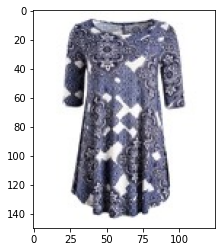

Score(Confidence): 1.0
Image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_54580005.0/referenceImages/9999_54580005
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_54580005.0
Product display name: Navy & White Geometric Arabesque Half-Sleeve Swing Tunic


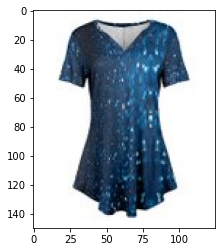

Score(Confidence): 0.45361801981925964
Image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_56848099.0/referenceImages/9999_56848099
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_56848099.0
Product display name: Blue & White Abstract V-Neck Tunic


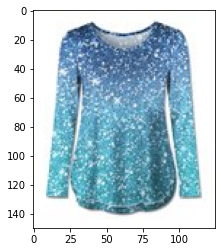

Score(Confidence): 0.3825170695781708
Image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_91163688.0/referenceImages/9999_91163688
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_91163688.0
Product display name: Blue Ombré Glitter-Print Crewneck Long-Sleeve Top


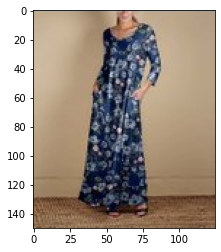

Score(Confidence): 0.36281618475914
Image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_100494058.0/referenceImages/9999_100494058
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_100494058.0
Product display name: Blue & Olive Floral Pocket V-Neck Maxi Dress


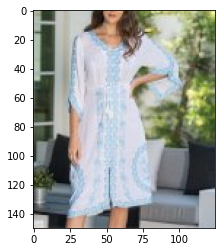

Score(Confidence): 0.33986395597457886
Image name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_85705566.0/referenceImages/9999_85705566
Product name: projects/q-gcp-4639-zulily-22-01/locations/us-west1/products/9999_85705566.0
Product display name: White Floral Medallion Embroidered Three-Quarter Sleeve Shift Dress


In [36]:
similar_product_file = get_similar_products_file(PROJECT_ID,
                                                 LOCATION,
                                                 PRODUCT_SET_ID, 
                                                 meta['category'][154],
                                                 "images_300/"+str(meta['new_product_id'][154])+'.jpg',
                                                 5)